In [ ]:
from dotenv import load_dotenv
load_dotenv()  # Load environment variables from .env file

In [ ]:
import os
PROJECT_PATH = os.getenv("PROJECT_PATH")

In [ ]:
from pathlib import Path
import pandas as pd

DATA_DIR = (f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct")
# DATA_DIR = (f"{PROJECT_PATH}/debug")

FILE_GLOB = "*_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv"
LIMIT_VALUE = 65535
REPLACEMENT_TEXT = "Token limit reached"

csv_files = sorted(DATA_DIR.glob(FILE_GLOB))
print(f"Found {len(csv_files)} files")

for csv_path in csv_files:
    print(f"\nProcessing: {csv_path.name}")

    # Read CSV; keep raw_response as string; avoid dtype inference edge cases
    df = pd.read_csv(
        csv_path,
        dtype={"raw_response": "string"},
        keep_default_na=False,
        low_memory=False,
    )

    if "tokens" not in df.columns:
        print("  - Skipped (no 'tokens' column).")
        continue

    # Coerce tokens to numeric to robustly catch string/integer forms
    tokens_numeric = pd.to_numeric(df["tokens"], errors="coerce")
    mask = tokens_numeric == LIMIT_VALUE
    updated_count = int(mask.sum())

    # Ensure raw_response column exists
    if "raw_response" not in df.columns:
        df["raw_response"] = pd.NA

    # Apply updates
    if updated_count > 0:
        df.loc[mask, "raw_response"] = REPLACEMENT_TEXT

    # Save back to the same file
    df.to_csv(csv_path, index=False)
    print(f"  - Updated rows: {updated_count}")

Found 10 files

Processing: Addition_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 0

Processing: Division_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 130

Processing: Exponentiation_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 44

Processing: HARD_Exponentiation_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 142

Processing: Interval_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 0

Processing: Mean_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 6

Processing: MinMax_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 0

Processing: Multiplication_decimal_uniform_test_10k_shuffle_google__gemini-2.5-flash_re_high.csv
  - Updated rows: 87

Processing: Sorting_decimal_uniform_test_10k_shuffle_google__gemi

In [ ]:
import os
import pandas as pd

# Trim results files to 500 lines
results_folder = f"{PROJECT_PATH}/frontier_model_analysis/results"

for file in os.listdir(results_folder):
    input_path = os.path.join(results_folder, file)
    if os.path.isfile(input_path):
        df = pd.read_csv(input_path, dtype=str)
        # Remove all rows except the first 500
        df = df.head(500)
        # Replace 10k with 500 in filename
        df.to_csv(input_path.replace("10k", "500"), index=False)

In [ ]:
import pandas as pd

overview_df = pd.read_csv(f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/analysis/overview_by_task_model_reasoning.csv")
overview_df

,task,model_name,reasoning_effort,n_samples,mean_usage_cost,sum_usage_cost,mean_usage_total_tokens,sum_usage_total_tokens,mean_logSMAPE_acc,est_cost_for_target_samples,est_tokens_for_target_samples
0,Addition,deepseek-chat-v3.1,high,100,0.000097,0.009679,146.860000,14686.0,0.938017,0.967904,1.468600e+06
1,Addition,deepseek-chat-v3.1,none,100,0.000097,0.009677,146.850000,14685.0,0.941712,0.967736,1.468500e+06
2,Addition,gemini-2.5-flash,high,100,0.004112,0.374159,1775.890110,161606.0,NaN,41.116352,1.775890e+07
3,Addition,gemini-2.5-flash,none,100,0.000101,0.010116,172.430000,17243.0,0.912577,1.011630,1.724300e+06
4,Addition,gemini-2.5-pro,high,100,0.054695,5.360079,5600.673469,548866.0,NaN,546.946811,5.600673e+07
...,...,...,...,...,...,...,...,...,...,...,...
102,Std,gpt-5,minimal,100,0.000022,0.002178,198.290000,19829.0,0.152246,0.217775,1.982900e+06
103,Std,kimi-k2-0905,none,100,0.000146,0.014604,168.530000,16853.0,0.141769,1.460430,1.685300e+06
104,Std,llama-4-maverick,none,100,0.000050,0.005042,200.350000,20035.0,0.122019,0.504246,2.003500e+06
105,Std,qwen3-235b-a22b-2507,none,100,0.000083,0.008262,225.650000,22565.0,0.134634,0.826176,2.256500e+06


In [ ]:
# Calc model costs stratified by model_name and reasoning_effort

total_costs_df = overview_df.groupby(['model_name', 'reasoning_effort'])['sum_usage_cost'].sum().reset_index()
total_token_df = overview_df.groupby(['model_name', 'reasoning_effort'])['sum_usage_total_tokens'].sum().reset_index()
df = pd.merge(total_costs_df, total_token_df, on=['model_name', 'reasoning_effort'])
df.sort_values(by='sum_usage_cost', ascending=False, inplace=True)
df

,model_name,reasoning_effort,sum_usage_cost,sum_usage_total_tokens
4,gemini-2.5-pro,high,59.749504,6110536.0
2,gemini-2.5-flash,high,8.660228,3571393.0
11,qwen3-235b-a22b-thinking-2507,high,2.934053,3415052.0
3,gemini-2.5-flash,none,2.721833,1225964.0
6,gpt-5,high,2.704417,5529585.0
5,gemini-2.5-pro,minimal,1.432989,279511.0
8,kimi-k2-0905,none,0.262589,174789.0
1,deepseek-chat-v3.1,none,0.221849,220269.0
0,deepseek-chat-v3.1,high,0.191216,201960.0
10,qwen3-235b-a22b-2507,none,0.069690,198106.0


In [ ]:
import pandas as pd

cost_analysis_p = f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/analysis/gemini_cost_analysis.csv"
cost_analysis_df = pd.read_csv(cost_analysis_p)
print("Total costs: ", cost_analysis_df["costs"].sum())
print("H1 costs: ", cost_analysis_df[cost_analysis_df["filename"].str.contains("_H1.csv")]["costs"].sum())
print("H2 costs: ", cost_analysis_df[cost_analysis_df["filename"].str.contains("_H2.csv")]["costs"].sum())
cost_analysis_df


Total costs:  164.69400100000001
H1 costs:  65.63537600000001
H2 costs:  99.05862499999999


,filename,model,task,costs,MAX_TOKENS
0,Addition_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-flash,Addition_decimal_uniform_test_10k_shuffle_google,0.680489,6
1,Addition_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-flash,Addition_decimal_uniform_test_10k_shuffle_google,1.469294,14
2,Addition_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-pro,Addition_decimal_uniform_test_10k_shuffle_google,2.651958,1
3,Addition_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-pro,Addition_decimal_uniform_test_10k_shuffle_google,5.924289,6
4,Division_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-flash,Division_decimal_uniform_test_10k_shuffle_google,9.428470,112
5,Division_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-flash,Division_decimal_uniform_test_10k_shuffle_google,11.071113,130
6,Division_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-pro,Division_decimal_uniform_test_10k_shuffle_google,6.115978,0
7,Division_decimal_uniform_test_10k_shuffle_goog...,gemini-2.5-pro,Division_decimal_uniform_test_10k_shuffle_google,11.959405,0
8,Exponentiation_decimal_uniform_test_10k_shuffl...,gemini-2.5-flash,Exponentiation_decimal_uniform_test_10k_shuffl...,10.083157,119
9,Exponentiation_decimal_uniform_test_10k_shuffl...,gemini-2.5-flash,Exponentiation_decimal_uniform_test_10k_shuffl...,12.078553,142


In [ ]:
import torch

mask = torch.randn(10) > 0.5
x = torch.randn(10, 10)

print(mask)
print(x)
print(torch.square(x[mask]))
print(torch.mean(torch.square(x[mask]), dim=-1, keepdim=True))
print(torch.sqrt(torch.mean(torch.square(x[mask]), dim=-1, keepdim=True)))

tensor([False,  True, False,  True, False, False, False, False, False, False])
tensor([[-4.0062e-01, -6.2921e-01,  4.6042e-01, -7.8200e-01,  1.1280e+00,
         -2.8221e-01, -1.2454e+00, -1.5869e+00, -1.6010e+00, -1.1176e+00],
        [-1.9935e-01,  3.3368e-01, -7.4216e-01,  1.9930e+00, -6.1934e-01,
         -1.6211e+00,  1.6400e+00, -5.4492e-01,  5.8045e-01, -1.1610e+00],
        [ 1.2455e+00, -1.8975e+00,  1.7488e+00,  9.9540e-01, -5.5117e-01,
          3.8756e-02,  6.8880e-01, -8.4822e-01, -5.9084e-02, -1.8156e+00],
        [ 3.4723e-01, -9.1748e-01,  5.4129e-01, -9.9899e-01, -1.8509e+00,
          1.0789e+00,  1.7704e+00,  1.0010e+00,  7.4621e-01, -1.8774e+00],
        [-1.4500e-02, -6.2002e-01, -1.5556e-01, -8.7345e-01, -3.0440e-01,
         -9.5130e-01,  1.0734e+00, -1.1202e+00, -1.5040e+00, -3.5720e-01],
        [ 2.4045e-01,  2.6116e-01,  4.0193e-03,  5.9834e-01, -9.9078e-02,
         -5.1258e-01,  4.9546e-01,  2.0934e+00,  4.1784e-01, -6.6461e-01],
        [ 1.0960e+00, -8.18

In [9]:
y = torch.tensor([-1.9935e-01,  3.3368e-01, -7.4216e-01,  1.9930e+00, -6.1934e-01,
         -1.6211e+00,  1.6400e+00, -5.4492e-01,  5.8045e-01, -1.1610e+00])

print(y**2)

tensor([0.0397, 0.1113, 0.5508, 3.9720, 0.3836, 2.6280, 2.6896, 0.2969, 0.3369,
        1.3479])


In [11]:
(-1.9935e-01)**2

0.0397404225

In [ ]:
# def make_tokens_matrix(df_all: pd.DataFrame, out_dir: Path) -> None:
#     """Create a compact 2x3 matrix of avg tokens vs avg performance (one subplot per task)."""
#     # Config: sizes and paddings
#     SCATTER_MARKER_SIZE = 180
#     LEGEND_MARKER_SIZE = 12
#     TICK_FONT_SIZE = 15
#     SUBTITLE_FONT_SIZE = 18
#     AXIS_FONT_SIZE = 16
#     TITLE_PAD = 6
#     XLABEL_PAD = 3
#     XTICK_PAD = 2

#     # Drop GPT 4.1 and remove bogus tokens
#     df_filt = df_all[~df_all["model"].str.contains("gpt-4.1", case=False, na=False)]
#     df_filt = df_filt[df_filt["tokens"] != 65535]

#     grp = (
#         df_filt[(df_filt["tokens"] >= 0) & np.isfinite(df_filt["tokens"])]
#         .groupby(["task", "model", "reasoning"], as_index=False)
#         .agg(avg_tokens=("tokens", "mean"), avg_perf=("performance", "mean"))
#     )
#     models = sorted(grp["model"].unique().tolist())
#     model_colors = get_color_maps(models)

#     # --- layout: 2 rows × 3 cols ------------------------------------------- # <<<
#     fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)  # <<<
#     axes = axes.flatten()

#     # Collect handles for a single legend
#     model_handles_done = set()
#     reasoning_handles_done = set()
#     model_handles: List[Any] = []
#     reasoning_handles: List[Any] = []

#     for idx, task in enumerate(TASKS_DISPLAY_ORDER):  # now length is 6
#         ax = axes[idx]
#         sub = grp[grp["task"] == task]

#         for (model, reasoning), df_grp in sub.groupby(["model", "reasoning"], as_index=False):
#             df_grp_df = cast(pd.DataFrame, df_grp)
#             col = reasoning_shade(model_colors[model], reasoning)
#             ax.scatter(
#                 df_grp_df["avg_tokens"],
#                 100.0 * df_grp_df["avg_perf"],
#                 s=SCATTER_MARKER_SIZE,
#                 c=[col],
#                 marker=REASONING_MARKERS.get(reasoning, "o"),
#                 alpha=0.9,
#                 edgecolors="k",
#                 linewidths=0.5,
#                 zorder=3,
#                 label=f"{model.replace('__','/')}: {reasoning}",
#             )

#             if model not in model_handles_done:
#                 mh = Line2D([0], [0], marker="o", color=model_colors[model],
#                             linestyle="None", markersize=LEGEND_MARKER_SIZE,
#                             label=model.replace("__", "/"))
#                 model_handles.append(mh)
#                 model_handles_done.add(model)

#             if reasoning not in reasoning_handles_done:
#                 base_demo = (0.2, 0.2, 0.8)
#                 rh = Line2D([0], [0], marker="o",
#                             color=reasoning_shade(base_demo, reasoning),
#                             linestyle="None", markersize=LEGEND_MARKER_SIZE,
#                             label=reasoning)
#                 reasoning_handles.append(rh)
#                 reasoning_handles_done.add(reasoning)

#         ax.set_title(task, fontsize=SUBTITLE_FONT_SIZE, pad=TITLE_PAD)
#         if idx > 2:  # top row only
#             ax.set_xlabel("Average tokens", fontsize=AXIS_FONT_SIZE, labelpad=XLABEL_PAD)
#         if idx % 3 == 0:  # first column only
#             ax.set_ylabel("Accuracy (%)", fontsize=AXIS_FONT_SIZE)
#         ax.grid(True, alpha=0.3, zorder=0)
#         ax.set_xscale("log")   # <<< log scale

#         # optional: custom ticks for clarity
#         ax.set_xticks([1e2, 1e3, 1e4])  
#         ax.set_xticklabels(["100", "1k", "10k"])

#         ax.set_yticks([0, 25, 50, 75, 100])
#         ax.set_ylim(0, 105)

#         ax.tick_params(axis="x", labelsize=TICK_FONT_SIZE, pad=XTICK_PAD)
#         ax.tick_params(axis="y", labelsize=TICK_FONT_SIZE)

#     # --- build model-only legend (top) + reasoning schema legend (under it) ----
#     # Figure bottom margin for stacked legends
#     fig.subplots_adjust(bottom=0.22)  # ~22% to fit two legend rows

#     # Collect unique display keys in desired order and map to colors
#     grp_disp = grp.copy()
#     grp_disp["display_model_key"] = grp_disp["model"].map(canonical_model_key)

#     disp_keys: List[str] = []
#     for m in models:
#         dk = canonical_model_key(m)
#         if dk not in disp_keys:
#             disp_keys.append(dk)

#     disp_to_color: Dict[str, Tuple[float, float, float]] = {}
#     for dk in disp_keys:
#         orig = next((m for m in models if canonical_model_key(m) == dk), models[0])
#         disp_to_color[dk] = model_colors[orig]

#     # Build one handle per display model (no reasoning in label)
#     model_only_handles: List[Line2D] = []
#     for dk in disp_keys:
#         model_only_handles.append(
#             Line2D(
#                 [0], [0],
#                 marker=".",
#                 linestyle="None",
#                 markersize=0,
#                 color=disp_to_color[dk],
#                 label=pretty_canonical_name(dk),
#             )
#         )

#     # 1) Model legend (top row at the bottom of the figure)
#     #    Tweak ncol to your taste; min(#models, 6) is usually readable.
#     ncol_models = 4
#     leg_models = fig.legend(
#         handles=model_only_handles,
#         loc="lower center",
#         bbox_to_anchor=(0.5, -0.05),
#         ncol=ncol_models,
#         frameon=True,
#         title="Models",
#         title_fontsize=16,
#         fontsize=16,
#         handlelength=0,     # no line length
#         handletextpad=0,    # no padding between handle and text
#     )
#     # Set font weight to bold for legend text
#     # for text in leg_models.get_texts():
#     #     text.set_fontweight('bold')
#     # leg_models.get_title().set_fontweight('bold')
#     # remove markers (handles) entirely, then color each label text
#     for text, color in zip(leg_models.get_texts(), [disp_to_color[dk] for dk in disp_keys]):
#         text.set_color(color)
#     fig.add_artist(leg_models)  # ensure this legend remains when adding another

#     # 2) Reasoning schema legend (stacked directly under the model legend)
#     base_demo = (0.2, 0.2, 0.8)
#     reasoning_labels = ["high", "minimal", "none"]
#     reasoning_handles = [
#         Line2D(
#             [0], [0],
#             marker=REASONING_MARKERS.get(r, "o"),
#             color=reasoning_shade(base_demo, r),
#             linestyle="None",
#             markersize=16,
#             label=r.capitalize(),
#         )
#         for r in reasoning_labels
#     ]
#     fig.legend(
#         handles=reasoning_handles,
#         loc="lower center",
#         bbox_to_anchor=(0.5, -0.18),  # a touch lower than the model legend
#         ncol=len(reasoning_handles),
#         frameon=False,
#         title="Reasoning (Marker & Shade)",
#         fontsize=16,
#         title_fontsize=16,
#     )

#     # If you keep tight_layout, give it a rectangle to avoid colliding with bottom legends
#     fig.tight_layout(rect=[0, 0.12, 1, 1])
#     fig.savefig(out_dir / "tokens_vs_performance_matrix.png", bbox_inches="tight")
#     plt.close(fig)

In [ ]:
#!/usr/bin/env python3
"""
Analyze numeracy benchmarks and generate publication-quality plots.

Pipeline:
1) Load all CSVs from the data directory.
2) Robustly parse raw_response -> parsed_answer (repair malformed JSON, code blocks, "<thought>" prefixes).
3) Recompute metrics:
   - Regression tasks (Addition, Division, Exponentiation, Mean, Multiplication, Std): logSMAPE_acc in [0,1].
   - Classification tasks (MinMax, Interval, Sorting): exact match (1 or 0) with normalization rules per task.
   If parsing fails, score = 0.
4) Save a cleaned copy per file (optional) and a global parsing-errors CSV.
5) Create plots:
   - Radar charts: one subplot per model, axes are tasks; include multiple reasoning efforts as lighter/darker shades.
   - Tokens vs performance scatter: x=tokens, y=performance; color=model (shade=reasoning), marker=task.
   - Difficulty vs performance: one plot per task; line per model+reasoning across difficulty_sd.
6) Print and save a summary table listing model/reasoning combinations missing results by task.

Assumptions:
- File pattern: <TASK>_decimal_uniform_test_10k_shuffle_<MODEL_SAFE>_re_<REASONING>.csv
- Columns present: difficulty_sd, answer, tokens, raw_response; may already include parsed_answer, logSMAPE_acc or correct.
- Data dir default: $PROJECT_PATH/test_data_2025-09-04_shuffled/
"""

from __future__ import annotations

import argparse
import json
import math
import re
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple, cast

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# Reuse helpers for baseline behavior
from utils import parse_answer as base_parse_answer  # type: ignore
from utils import parse_numbers_from_text, logSMAPE as logsmape_py  # type: ignore

# Tasks as used in the benchmark
TASKS: List[str] = [
    "Addition",
    "Division",
    "Exponentiation",
    "Interval",
    "Mean",
    "MinMax",
    "Multiplication",
    "Sorting",
    "Std",
]
# Display order for tasks in plots (subplots and radar axes)
TASKS_DISPLAY_ORDER: List[str] = [
    "Addition",
    "Multiplication",
    "MinMax",
    "Interval",
    "Sorting",
    "Division",ist 
    "Exponentiation",
    "Mean",
    "Std",
]
TASKS_DISPLAY_ORDER_RADAR: List[str] = [
    "Mean",
    "Std",
    "Exponentiation",
    "Division",
    "Multiplication",
    "Addition",
    "MinMax",
    "Interval",
    "Sorting",
]
REGRESSION_TASKS: set[str] = {
    "Addition",
    "Division",
    "Exponentiation",
    "Mean",
    "Multiplication",
    "Std",
}
CLASSIFICATION_TASKS: set[str] = {"MinMax", "Interval", "Sorting"}

# Reasoning order for shade intensity (light -> dark)
REASONING_LEVELS: List[str] = ["none", "minimal", "low", "medium", "maximal"]
# Requested reasoning order for legends and plotting priority
REASONING_ORDER: List[str] = ["maximal", "low", "minimal", "none"]


def reasoning_sort_key(r: str) -> int:
    try:
        return REASONING_ORDER.index(r)
    except ValueError:
        # place unknown at end
        return len(REASONING_ORDER)


# Marker shapes by reasoning level
REASONING_MARKERS: Dict[str, str] = {
    "maximal": "*",  # star
    "low": "s",  # square
    "minimal": "^",  # triangle
    "none": "o",  # circle
}

# File name regex
FILENAME_RE = re.compile(
    r"^(?P<task>[A-Za-z]+)_decimal_uniform_test_10k_shuffle_(?P<model>.+?)_re_(?P<reasoning>[A-Za-z]+)\.csv$"
)

# Seaborn/Matplotlib styling for publication-quality figures
sns.set_theme(context="talk", style="whitegrid", font_scale=1.2)
mpl.rcParams.update(
    {
        "figure.dpi": 140,
        "savefig.dpi": 300,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.titlepad": 14,
        "axes.labelpad": 10,
        "legend.title_fontsize": 12,
        "pdf.fonttype": 42,  # Editable text in PDFs
        "ps.fonttype": 42,
    }
)


@dataclass(frozen=True)
class FileKey:
    task: str
    model: str
    reasoning: str
    path: Path


@dataclass
class ParsedRecord:
    ok: bool
    parsed_answer: str
    reason: str = ""


def find_files(data_dir: Path) -> List[FileKey]:
    files: List[FileKey] = []
    for p in sorted(data_dir.glob("*.csv")):
        m = FILENAME_RE.match(p.name)
        if not m:
            continue
        task = m.group("task")
        model = m.group("model")
        reasoning = m.group("reasoning")
        files.append(FileKey(task=task, model=model, reasoning=reasoning, path=p))
    return files


def strip_code_fences(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove code fences ```...```, including optional language tags
    text = re.sub(r"```(?:json|JSON|python|txt)?\s*", "", text, flags=re.IGNORECASE)
    text = text.replace("```", " ")
    return text.strip()


def remove_known_prefixes(text: str) -> str:
    if not text:
        return text
    # Remove leading labels like "JSON", "Answer:", "<thought>...</thought>"
    text = text.strip()
    text = re.sub(r"^\s*(JSON|Json|json)\s*[:\-]?\s*", "", text)
    # Drop simple XML-like thought wrappers
    text = re.sub(r"<thought>.*?</thought>", " ", text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(
        r"<reasoning>.*?</reasoning>", " ", text, flags=re.IGNORECASE | re.DOTALL
    )
    return text.strip()


def extract_first_json_object(text: str) -> Optional[str]:
    """
    Extract the first balanced JSON object substring containing the key "answer".
    Conservative bracket matching to avoid catastrophic regex on nested braces.
    """
    if not text:
        return None
    start_positions = [i for i, ch in enumerate(text) if ch == "{"]
    for start in start_positions:
        depth = 0
        for end in range(start, len(text)):
            if text[end] == "{":
                depth += 1
            elif text[end] == "}":
                depth -= 1
                if depth == 0:
                    candidate = text[start : end + 1]
                    if '"answer"' in candidate or "'answer'" in candidate:
                        return candidate
                    break
    return None


def parse_interval_label(text: str) -> Optional[str]:
    if not isinstance(text, str):
        return None
    # Match A-F possibly quoted, surrounded by non-word or string boundaries
    m = re.search(r"(?i)(?<![A-Z])([A-F])(?![A-Z])", text)
    if m:
        return m.group(1).upper()
    return None


def parse_list_like(text: str) -> Optional[List[float]]:
    if not isinstance(text, str):
        return None
    # Try JSON list first
    cleaned = text.strip()
    # If looks like a list without surrounding brackets, attempt to add
    looks_like_comma_numbers = (
        re.fullmatch(r"\s*[-+]?[\d.]+(?:\s*,\s*[-+]?[\d.]+)*\s*", cleaned) is not None
    )
    try_candidates = []
    if cleaned.startswith("[") and cleaned.endswith("]"):
        try_candidates.append(cleaned)
    elif looks_like_comma_numbers:
        try_candidates.append("[" + cleaned + "]")
    # Extract list-like substring if present
    list_match = re.search(r"\[(.*?)\]", cleaned, flags=re.DOTALL)
    if list_match:
        try_candidates.append("[" + list_match.group(1) + "]")

    for cand in try_candidates:
        try:
            arr = json.loads(cand)
            if isinstance(arr, list) and all(isinstance(x, (int, float)) for x in arr):
                return [float(x) for x in arr]
            # If values are strings but convertible to floats
            if isinstance(arr, list) and all(
                isinstance(x, (int, float, str)) for x in arr
            ):
                return [float(str(x).strip()) for x in arr]
        except Exception:
            continue

    # Fallback: extract numbers loosely
    nums = parse_numbers_from_text(cleaned)
    return nums if nums else None


def robust_parse_answer(response: str, task: str) -> ParsedRecord:
    """
    Enhanced parser:
    - Try base JSON parse (eval_scripts.utils.parse_answer)
    - If empty, strip code fences/prefixes and try again
    - If still empty, extract embedded JSON object
    - Task-specific fallbacks:
        Interval -> letter A-F
        Sorting  -> list of numbers
        Others   -> first numeric token
    """
    if not isinstance(response, str):
        return ParsedRecord(ok=False, parsed_answer="", reason="non_string_response")

    # 0) If only one pair of json braces, remove everything outside of it
    if response.count("{") == 1 and response.count("}") == 1:
        response = response.split("{")[1].split("}")[0]
        response = "{" + response + "}"

    # 1) Try base parser
    try:
        keep_raw = task in {"MinMax", "Sorting"}
        ans = base_parse_answer(response, keep_answer_raw=keep_raw) or ""
    except Exception:
        ans = ""
    if ans:
        return ParsedRecord(ok=True, parsed_answer=str(ans))

    # 2) Strip fences/prefixes and retry base parser
    cleaned = strip_code_fences(remove_known_prefixes(response))
    try:
        keep_raw = task in {"MinMax", "Sorting"}
        ans2 = base_parse_answer(cleaned, keep_answer_raw=keep_raw) or ""
    except Exception:
        ans2 = ""
    if ans2:
        return ParsedRecord(ok=True, parsed_answer=str(ans2))

    # 3) Extract embedded JSON then parse
    embedded = extract_first_json_object(cleaned)
    if embedded:
        try:
            if task in {"MinMax", "Sorting"}:
                obj = json.loads(embedded, parse_float=str, parse_int=str)
            else:
                obj = json.loads(embedded)
            if isinstance(obj, dict) and "answer" in obj:
                return ParsedRecord(ok=True, parsed_answer=str(obj["answer"]))
        except Exception:
            pass

    # 4) Task-specific heuristics
    if task == "Interval":
        label = parse_interval_label(cleaned)
        if label:
            return ParsedRecord(ok=True, parsed_answer=label)

    if task == "Sorting":
        arr = parse_list_like(cleaned)
        if arr is not None and len(arr) > 0:
            return ParsedRecord(
                ok=True, parsed_answer=json.dumps(arr, separators=(",", ":"))
            )

    # Numeric fallback for numeric tasks
    nums = parse_numbers_from_text(cleaned)
    if nums:
        # For MinMax keep the raw numeric token to avoid e-notation changes
        if task == "MinMax":
            m = re.search(
                r"(?:^| |)[+-]?(?:(?:0(?!\.[0-9]))|(?:[0-9]*[.][0-9]+)|(?:[1-9][0-9]*))(?:[eE][+-]?[0-9]+)?",
                cleaned,
            )
            if m:
                return ParsedRecord(ok=True, parsed_answer=m.group().strip())
        return ParsedRecord(ok=True, parsed_answer=str(nums[0]))

    return ParsedRecord(ok=False, parsed_answer="", reason="unparseable")


def normalize_truth(task: str, truth_raw: str) -> Tuple[str, Any]:
    """
    Return (normalized_string, structured_value) for ground truth to compare fairly.
    - Interval: uppercase single letter A-F
    - Sorting: JSON minified numeric list
    - MinMax: preserve exact numeric string (strip spaces and quotes)
    - Regression tasks: float value
    """
    if task == "Interval":
        v = parse_interval_label(truth_raw or "") or ""
        return v, v
    if task == "Sorting":
        arr = parse_list_like(truth_raw or "")
        return (json.dumps(arr, separators=(",", ":")) if arr is not None else ""), arr
    if task == "MinMax":
        s = str(truth_raw or "").strip().strip('"').strip("'")
        return s, s
    # Regression
    try:
        val = float(str(truth_raw))
    except Exception:
        val = float("nan")
    return str(val), val


def compute_sample_score(
    task: str, parsed_ans: str, truth_norm: Tuple[str, Any]
) -> float:
    """
    Return performance in [0,1].
    - Regression: logSMAPE between parsed float and truth float
    - Interval, Sorting: exact match after normalization
    - MinMax: exact string match (as specified)
    Unparseable -> 0
    """
    if task in REGRESSION_TASKS:
        try:
            pred = float(str(parsed_ans))
            true_val: float = truth_norm[1]
            if math.isnan(true_val):
                return 0.0
            return float(logsmape_py(pred, true_val))
        except Exception:
            return 0.0

    if task == "Interval":
        return (
            1.0 if (str(parsed_ans).strip().upper() == (truth_norm[0] or "")) else 0.0
        )

    if task == "Sorting":
        # Compare as numeric arrays with exact order
        try:
            pred_arr = parse_list_like(parsed_ans) or []
            true_arr = truth_norm[1] or []
            if len(pred_arr) != len(true_arr):
                return 0.0
            return (
                1.0
                if all(float(a) == float(b) for a, b in zip(pred_arr, true_arr))
                else 0.0
            )
        except Exception:
            return 0.0

    if task == "MinMax":
        # Exact numeric string match (trim quotes/spaces)
        pred_s = str(parsed_ans).strip().strip('"').strip("'")
        return 1.0 if pred_s == (truth_norm[0] or "") else 0.0

    return 0.0


def lighten_color(
    color: Tuple[float, float, float], factor: float
) -> Tuple[float, float, float]:
    """Lighten color by blending toward white. factor in [0,1]; 0=no change, 1=white."""
    r, g, b = color
    return (r + (1 - r) * factor, g + (1 - g) * factor, b + (1 - b) * factor)


COLOR_HEX = {
    "deepseek-chat": "#0072B2",  # Blue
    "gemini 2.5 pro": "#E69F00",  # Orange
    "gemini 2.5 flash": "#9E0D19",  # Red
    "kimi k2": "#40531B",  # Dark Green
    "llama 4": "#009E73",  # Bluish Green
    "gpt 4.1": "#D55E00",  # Vermilion
    "gpt 5": "#000000",  # Black
    "gpt oss": "#C6A15B",  # Brown
    "qwen3": "#CC79A7",  # Reddish Purple
}


def canonical_model_key(model: str) -> str:
    s = model.replace("__", "/").lower()
    if "deepseek" in s:
        return "deepseek-chat"
    if "gemini-2.5-flash" in s:
        return "gemini 2.5 flash"
    if "gemini-2.5-pro" in s:
        return "gemini 2.5 pro"
    if "llama-4" in s:
        return "llama 4"
    if "kimi" in s:
        return "kimi k2"
    if "gpt-4.1" in s:
        return "gpt 4.1"
    if "gpt-5" in s:
        return "gpt 5"
    if "gpt-oss" in s or "gpt-0ss" in s or "oss-120b" in s or "gpt oss" in s:
        return "gpt oss"
    if "qwen3" in s or "qwen-3" in s or "qwen3-" in s or "qwen/" in s:
        return "qwen3"
    return s


def get_color_maps(models: List[str]) -> Dict[str, Tuple[float, float, float]]:
    """Return a color (RGB tuple) per exact model string using the specified palette.

    - Maps each model to one of the 9 requested base colors via canonical_model_key.
    - Falls back to HUSL for any models not covered by the 9 keys.
    """
    unique_models = sorted(set(models))
    fallback_palette = sns.color_palette("husl", n_colors=len(unique_models))
    fallback_iter = iter(fallback_palette)
    mapping: Dict[str, Tuple[float, float, float]] = {}
    for m in unique_models:
        key = canonical_model_key(m)
        if key in COLOR_HEX:
            mapping[m] = mcolors.to_rgb(COLOR_HEX[key])
        else:
            mapping[m] = next(fallback_iter)
    return mapping


def pretty_model_name(model: str) -> str:
    s = model.replace("__", "/").lower()
    if "deepseek" in s:
        return "DeepSeek v3.1"
    if "gemini-2.5-flash" in s:
        return "Gemini 2.5 Flash"
    if "gemini-2.5-pro" in s:
        return "Gemini 2.5 Pro"
    if "llama-4" in s:
        return "Llama 4 Maverick"
    if "kimi" in s:
        return "Kimi K2 0905"
    if "gpt-4.1" in s:
        return "GPT 4.1"
    if "gpt-5" in s:
        return "GPT 5"
    if "gpt-oss" in s or "gpt-0ss" in s or "oss-120b" in s or "gpt oss" in s:
        return "GPT OSS 120B"
    if "qwen3" in s or "qwen-3" in s or "qwen3-" in s or "qwen/" in s:
        return "Qwen3 235B 2507"
    return model.replace("__", "/")


def pretty_canonical_name(key: str) -> str:
    key = key.lower()
    mapping = {
        "deepseek-chat": "DeepSeek v3.1",
        "gemini 2.5 flash": "Gemini 2.5 Flash",
        "gemini 2.5 pro": "Gemini 2.5 Pro",
        "llama 4": "Llama 4 Maverick",
        "kimi k2": "Kimi K2 0905",
        "gpt 4.1": "GPT 4.1",
        "gpt 5": "GPT 5",
        "gpt oss": "GPT OSS 120B",
        "qwen3": "Qwen3 235B 2507",
    }
    return mapping.get(key, key)

def prety_task_names(task_names: List[str]) -> List[str]:
    mapping = {
        "Addition": "Add",
        "Multiplication": "Mult",
        "Exponentiation": "Exp",
        "Division": "Div",
        "Mean": "Mean",
        "Std": "Std",
        "MinMax": "MinMax",
        "Interval": "Interval",
    }
    return [mapping.get(task, task) for task in task_names]


def reasoning_shade(
    base: Tuple[float, float, float], reasoning: str
) -> Tuple[float, float, float]:
    # Map reasoning to lightness; higher effort -> darker (factor closer to 0)
    rank = REASONING_LEVELS.index(reasoning) if reasoning in REASONING_LEVELS else 0
    # none=0.65, minimal=0.5, low=0.35, medium=0.2, high=0.0
    factors = {0: 0.65, 1: 0.5, 2: 0.35, 3: 0.2, 4: 0.0}
    return lighten_color(base, factors.get(rank, 0.5))


TASK_MARKERS = {
    "Addition": "o",
    "Division": "s",
    "Exponentiation": "v",
    "Interval": "D",
    "Mean": "^",
    "MinMax": "P",
    "Multiplication": "X",
    "Sorting": "*",
    "Std": "h",
}


def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)


def make_radar_charts(df_all: pd.DataFrame, out_dir: Path) -> None:
    """
    One subplot per model (up to 10 per figure in a 2x5 grid).
    Axes: tasks (0..100). Multiple reasoning efforts per model as shades of the model color.
    Annotates exact percentage scores on each axis.
    """
    # Aggregate performance; drop GPT 4.1; merge Qwen variants by canonical key
    perf_raw = df_all.groupby(["model", "reasoning", "task"], as_index=False)[
        "performance"
    ].mean()
    perf_raw = perf_raw[
        ~perf_raw["model"].str.contains("gpt-4.1", case=False, na=False)
    ]
    perf_raw["display_key"] = perf_raw["model"].map(canonical_model_key)
    perf = perf_raw.groupby(["display_key", "reasoning", "task"], as_index=False)[
        "performance"
    ].mean()
    # Ordered display models (2x4 grid)
    ordered_keys = [
        "gpt oss",
        "qwen3",
        "deepseek-chat",
        "kimi k2",
        "gpt 5",
        "gemini 2.5 pro",
        "gemini 2.5 flash",
        "llama 4",
    ]
    present_keys = [
        k for k in ordered_keys if k in perf["display_key"].unique().tolist()
    ]
    # Color mapping by display key
    disp_to_color = {
        k: mcolors.to_rgb(COLOR_HEX[k]) for k in present_keys if k in COLOR_HEX
    }

    # Prepare axes order and wrap-around angle
    axes_labels = TASKS_DISPLAY_ORDER_RADAR.copy()
    num_axes = len(axes_labels)
    angles = np.linspace(0, 2 * np.pi, num_axes, endpoint=False).tolist()
    angles += angles[:1]  # close loop

    # Plot in 2x4 grids; multiple pages if more than 8 display models
    chunk_size = 8
    for start in range(0, len(present_keys), chunk_size):
        subset_models = present_keys[start : start + chunk_size]
        nrows, ncols = 2, 4
        fig, axs = plt.subplots(
            nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True), figsize=(15, 7)
        )
        axs = axs.flatten()
        fig.subplots_adjust(hspace=0.2)

        for ax_idx, (ax, disp_key) in enumerate(zip(axs, subset_models)):
            sub = perf[perf["display_key"] == disp_key]
            base_col = disp_to_color.get(disp_key, (0.3, 0.3, 0.3))
            reasonings = sorted(sub["reasoning"].unique(), key=reasoning_sort_key)

            for r_idx, reasoning in enumerate(reasonings):
                vals_pct: List[float] = []
                sub_r = sub[sub["reasoning"] == reasoning]
                for t in axes_labels:
                    v = sub_r.loc[sub_r["task"] == t, "performance"].mean()
                    vals_pct.append(100.0 * float(v) if pd.notna(v) else 0.0)
                vals_closed = vals_pct + vals_pct[:1]

                col = reasoning_shade(base_col, reasoning)
                ax.plot(
                    angles,
                    vals_closed,
                    color=col,
                    linewidth=2.5,
                    label=reasoning,
                    zorder=3,
                )
                ax.fill(angles, vals_closed, color=col, alpha=0.15, zorder=2)
                # Use reasoning markers on radar points
                marker = REASONING_MARKERS.get(reasoning, "o")
                ax.scatter(
                    angles[:-1],
                    vals_pct,
                    s=100,
                    color=col,
                    edgecolors="k",
                    linewidths=0.3,
                    marker=marker,
                    zorder=10,
                    clip_on=False
                )

                # Annotate exact scores with slight outward offset per reasoning to reduce overlap
                offset_per_level = 1.2
                base_offset = 1.5
                for ang, val in zip(angles[:-1], vals_pct):
                    radius = min(100.0, val + base_offset + r_idx * offset_per_level)
                    # ax.text(
                    #     ang,
                    #     radius,
                    #     f"{val:.1f}",
                    #     color=col,
                    #     fontsize=12,
                    #     ha="center",
                    #     va="bottom",
                    #     #weight="bold",
                    #     zorder=5,
                    # )

            if ax_idx >= ncols:  # bottom row (since you have 2 rows)
                ax.text(
                    0.5, -0.25,
                    pretty_canonical_name(disp_key),
                    transform=ax.transAxes,
                    ha="center", va="top", fontsize=14
                )
            else:
                ax.set_title(pretty_canonical_name(disp_key), pad=16, fontsize=14)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(prety_task_names(axes_labels), fontsize=12)
            # ax.tick_params(axis='x', pad=8)
            ax.set_yticks([20, 40, 60, 80, 100])
            ax.set_yticklabels([20, 40, 60, 80, 100], fontsize=11)
            ax.set_ylim(0, 100)
            ax.set_rlabel_position(270) 
            ax.grid(True, alpha=0.4, zorder=1)

            task_tick_padding_dict = {
                "Addition": 5, 
                "Multiplication": 5,
                "Exponentiation": 0,
                "Division": 0,
                "Mean": 5,
                "Sorting": 5,
            } 
            for tick, label in zip(ax.xaxis.get_major_ticks(), axes_labels):
                tick.set_pad(task_tick_padding_dict.get(label, 0))


            # No legends on radar plots per request

        # Hide any unused axes
        for j in range(len(subset_models), nrows * ncols):
            axs[j].axis("off")

        # Add a horizontal shade legend across the top (Reasoning levels)
        base_demo = (0.2, 0.2, 0.8)
        reasoning_labels = ["maximal", "minimal", "none"]
        reasoning_handles = [
            Line2D(
                [0],
                [0],
                marker=REASONING_MARKERS.get(r, "o"),
                color=reasoning_shade(base_demo, r),
                linestyle="None",
                markersize=10,
                label=r.capitalize(),
            )
            for r in reasoning_labels
        ]
        fig.legend(
            handles=reasoning_handles,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.05),
            ncol=len(reasoning_handles),
            frameon=True,
            title="Reasoning (marker & shade)",
            fontsize=12,
            title_fontsize=12,
        )
        fig.tight_layout(rect=(0, 0, 1, 0.95))
        fig.subplots_adjust(hspace=0.4, wspace=0.0)
        out_path = out_dir / f"radar_models.png"
        fig.savefig(out_path, bbox_inches="tight")
        plt.close(fig)



def make_tokens_matrix(df_all: pd.DataFrame, out_dir: Path) -> None:
    """Create a compact 2x5 matrix of avg tokens vs avg performance (one subplot per task)."""
    # Config: sizes and paddings
    SCATTER_MARKER_SIZE = 350  
    LEGEND_MARKER_SIZE = 18    
    TITLE_PAD = 6             
    XLABEL_PAD = 3             
    XTICK_PAD = 2              
    TICK_LABEL_SIZE = 20
    AXIS_LABEL_SIZE = 20
    SUBPLOT_TITLE_SIZE = 24
    LEGEND_FONT_SIZE = 22

    # Config: x-limits by task
    LONG_LIMIT = 35_000
    SHORT_LIMIT = 1_600
    TASKS_LONG = {"Addition", "Multiplication", "Division", "Exponentiation", "Mean", "Std"}
    TASKS_SHORT = {"MinMax", "Interval", "Sorting"}

    # Drop GPT 4.1
    df_filt = df_all[~df_all["model"].str.contains("gpt-4.1", case=False, na=False)]
    # Remove max reasoning error gemini 
    df_filt = df_filt[df_filt["tokens"] != 65535]
    grp = (
        df_filt[(df_filt["tokens"] >= 0) & np.isfinite(df_filt["tokens"])]
        .groupby(["task", "model", "reasoning"], as_index=False)
        .agg(avg_tokens=("tokens", "mean"), avg_perf=("performance", "mean"))
    )
    models = sorted(grp["model"].unique().tolist())
    model_colors = get_color_maps(models)

    # fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=False, sharey=False)
    fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=False, sharey=True)
    axes = axes.flatten()

    # Collect handles for a single legend
    model_handles_done = set()
    reasoning_handles_done = set()
    model_handles: List[Any] = []
    reasoning_handles: List[Any] = []

    for idx, task in enumerate(TASKS_DISPLAY_ORDER):
        ax = axes[idx]
        sub = grp[grp["task"] == task]
        if sub.empty:
            ax.set_title(task, fontsize=13, pad=TITLE_PAD)
            ax.axis("off")
            continue
        for (model, reasoning), df_grp in sub.groupby(["model", "reasoning"], as_index=False):
            df_grp_df = cast(pd.DataFrame, df_grp)
            col = reasoning_shade(model_colors[model], reasoning)
            sc = ax.scatter(
                df_grp_df["avg_tokens"],
                100.0 * df_grp_df["avg_perf"],
                s=SCATTER_MARKER_SIZE,
                c=[col],
                marker=REASONING_MARKERS.get(reasoning, "o"),
                alpha=0.9,
                edgecolors="k",
                linewidths=0.5,
                zorder=10,
                clip_on=False,
                label=f"{model.replace('__','/')}: {reasoning}",
            )
            if model not in model_handles_done:
                mh = Line2D(
                    [0],
                    [0],
                    marker="o",
                    color=model_colors[model],
                    linestyle="None",
                    markersize=LEGEND_MARKER_SIZE,
                    label=model.replace("__", "/"),
                )
                model_handles.append(mh)
                model_handles_done.add(model)
            if reasoning not in reasoning_handles_done:
                # Use a neutral blue to demonstrate light/dark mapping for reasoning
                base_demo = (0.2, 0.2, 0.8)
                rh = Line2D(
                    [0],
                    [0],
                    marker="o",
                    color=reasoning_shade(base_demo, reasoning),
                    linestyle="None",
                    markersize=LEGEND_MARKER_SIZE,
                    label=reasoning,
                )
                reasoning_handles.append(rh)
                reasoning_handles_done.add(reasoning)

        # keep subplot title as the task name
        ax.set_title(task, fontsize=SUBPLOT_TITLE_SIZE, pad=TITLE_PAD)
        ax.set_xlabel("Average tokens", fontsize=AXIS_LABEL_SIZE, labelpad=XLABEL_PAD)
        ax.set_yticks([0, 25, 50, 75, 100])
        if idx % 5 == 0:
            ax.set_ylabel("log sMAPE (%)", fontsize=AXIS_LABEL_SIZE)
        if idx == 2:
            ax.set_ylabel("Exact Match\nAccuracy (%)", fontsize=AXIS_LABEL_SIZE)

        # Apply requested x-limits by task
        if task in TASKS_LONG:
            ax.set_xscale("log")   # <<< log scale
            ax.set_xlim(0, 4e4)
            ax.set_xticks([1e2, 1e3, 1e4])  
            ax.set_xticklabels(["100", "1k", "10k"])
        elif task in TASKS_SHORT:
            ax.set_xlim(-100, SHORT_LIMIT)
            ax.set_xticks([0, 500, 1000, 1500])

        # Style
        ax.grid(True, alpha=0.3, zorder=0)
        ax.tick_params(axis="x", labelsize=TICK_LABEL_SIZE, pad=XTICK_PAD)
        ax.tick_params(axis="y", labelsize=TICK_LABEL_SIZE)

    # Turn off last empty axis and place a combined legend inside it (bottom-right empty cell)
    if len(axes) >= 10:
        empty_ax = axes[9]
        empty_ax.axis("off")
        # Build combined legend entries: (display model, reasoning)
        # grp_disp = grp.copy()
        # grp_disp["display_model_key"] = grp_disp["model"].map(canonical_model_key)
        # present_pairs = (
        #     grp_disp[["display_model_key", "reasoning"]]
        #     .drop_duplicates()
        #     .values.tolist()
        # )
        # # Colors by display model           
        # disp_keys = []
        # for m in models:
        #     dk = canonical_model_key(m)
        #     if dk not in disp_keys:
        #         disp_keys.append(dk)
        # disp_to_color: Dict[str, Tuple[float, float, float]] = {}
        # for dk in disp_keys:
        #     orig = next((m for m in models if canonical_model_key(m) == dk), models[0])
        #     disp_to_color[dk] = model_colors[orig]

        # def pair_sort_key(pr: List[str]) -> Tuple[int, int]:
        #     dk, r = pr
        #     try:
        #         dk_idx = disp_keys.index(dk)
        #     except ValueError:
        #         dk_idx = 999
        #     return (dk_idx, reasoning_sort_key(r))

        # present_pairs.sort(key=pair_sort_key)

        # combined_handles: List[Line2D] = []
        # for dk, r in present_pairs:
        #     color = disp_to_color.get(dk, (0.3, 0.3, 0.3))
        #     marker = REASONING_MARKERS.get(r, "o")
        #     label = f"{pretty_canonical_name(dk):<{20}}- {r.capitalize()}"
        #     combined_handles.append(
        #         Line2D(
        #             [0],
        #             [0],
        #             marker=marker,
        #             color=color,
        #             linestyle="None",
        #             markersize=LEGEND_MARKER_SIZE,
        #             label=label,
        #         )
        #     )

        # from matplotlib.font_manager import FontProperties
        # mono = FontProperties(family='DejaVu Sans Mono', size=12)
        # empty_ax.legend(
        #     handles=combined_handles,
        #     loc="upper left",
        #     bbox_to_anchor=(0.0, 1.2),
        #     frameon=True,
        #     title="Model — Reasoning",
        #     title_fontsize=14,
        #     ncol=1,
        #     prop=mono
        # )

            # --- build model-only legend (top) + reasoning schema legend (under it) ----
        # Figure bottom margin for stacked legends
        # fig.subplots_adjust(bottom=0.22)  # ~22% to fit two legend rows

        # Collect unique display keys in desired order and map to colors
        grp_disp = grp.copy()
        grp_disp["display_model_key"] = grp_disp["model"].map(canonical_model_key)

        disp_keys: List[str] = []
        for m in models:
            dk = canonical_model_key(m)
            if dk not in disp_keys:
                disp_keys.append(dk)

        disp_to_color: Dict[str, Tuple[float, float, float]] = {}
        for dk in disp_keys:
            orig = next((m for m in models if canonical_model_key(m) == dk), models[0])
            disp_to_color[dk] = model_colors[orig]

        # Build one handle per display model (no reasoning in label)
        model_only_handles: List[Line2D] = []
        for dk in disp_keys:
            model_only_handles.append(
                Line2D(
                    [0], [0],
                    marker=".",
                    linestyle="None",
                    markersize=0,
                    color=disp_to_color[dk],
                    label=pretty_canonical_name(dk),
                )
            )

        # 1) Model legend (top row at the bottom of the figure)
        #    Tweak ncol to your taste; min(#models, 6) is usually readable.
        ncol_models = 1
        leg_models = fig.legend(
            handles=model_only_handles,
            loc="lower left",
            bbox_to_anchor=(0.81, -0.15),
            ncol=ncol_models,
            frameon=True,
            title="Models",
            title_fontsize=LEGEND_FONT_SIZE,
            fontsize=LEGEND_FONT_SIZE,
            handlelength=0,     # no line length
            handletextpad=0,    # no padding between handle and text
        )
        # Set font weight to bold for legend text
        # for text in leg_models.get_texts():
        #     text.set_fontweight('bold')
        # leg_models.get_title().set_fontweight('bold')
        # remove markers (handles) entirely, then color each label text
        for text, color in zip(leg_models.get_texts(), [disp_to_color[dk] for dk in disp_keys]):
            text.set_color(color)
        fig.add_artist(leg_models)  # ensure this legend remains when adding another

        # 2) Reasoning schema legend (stacked directly under the model legend)
        # base_demo = (0.2, 0.2, 0.8)
        # reasoning_labels = ["high", "minimal", "none"]
        # reasoning_handles = [
        #     Line2D(
        #         [0], [0],
        #         marker=REASONING_MARKERS.get(r, "o"),
        #         color=reasoning_shade(base_demo, r),
        #         linestyle="None",
        #         markersize=LEGEND_MARKER_SIZE,
        #         label=r.capitalize(),
        #     )
        #     for r in reasoning_labels
        # ]
        # reasoning_legend = fig.legend(
        #     handles=reasoning_handles,
        #     loc="lower left",
        #     bbox_to_anchor=(0.94, 0.225),
        #     ncol=1,
        #     frameon=True,
        #     title="Reasoning\n(Marker & Shade)",
        #     fontsize=LEGEND_FONT_SIZE,
        #     title_fontsize=LEGEND_FONT_SIZE,
        # )
        # reasoning_legend.get_title().set_ha('center')

        base_demo = (0.2, 0.2, 0.8)
        reasoning_labels = ["maximal", "minimal", "none"]
        reasoning_handles = [
            Line2D(
                [0], [0],
                marker=REASONING_MARKERS.get(r, "o"),
                color=reasoning_shade(base_demo, r),
                linestyle="None",
                markersize=LEGEND_MARKER_SIZE,
                label=r.capitalize(),
            )
            for r in reasoning_labels
        ]
        fig.legend(
            handles=reasoning_handles,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=len(reasoning_handles),
            frameon=True,
            title="Reasoning (Marker & Shade)",
            fontsize=LEGEND_FONT_SIZE,
            title_fontsize=LEGEND_FONT_SIZE,
        )

    fig.tight_layout()
    fig.savefig(out_dir / "tokens_vs_performance_matrix.png", bbox_inches="tight")
    plt.close(fig)


In [ ]:

df_all = pd.read_csv(f"PROJECT_PATH/test_data_2025-09-04_shuffled_correct/analysis/combined_samples_long.csv")
df_all = df_all[
            ~((df_all["model"] == "openai__gpt-oss-120b") & (df_all["reasoning"] == "low"))
        ]
make_tokens_matrix(df_all, (f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/analysis"))
make_radar_charts(df_all, (f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/analysis"))

/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)
/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)
/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)
/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)
/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)
/tmp/ipykernel_439290/3335103605.py:837: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4e4)


# Difficulty Analysis

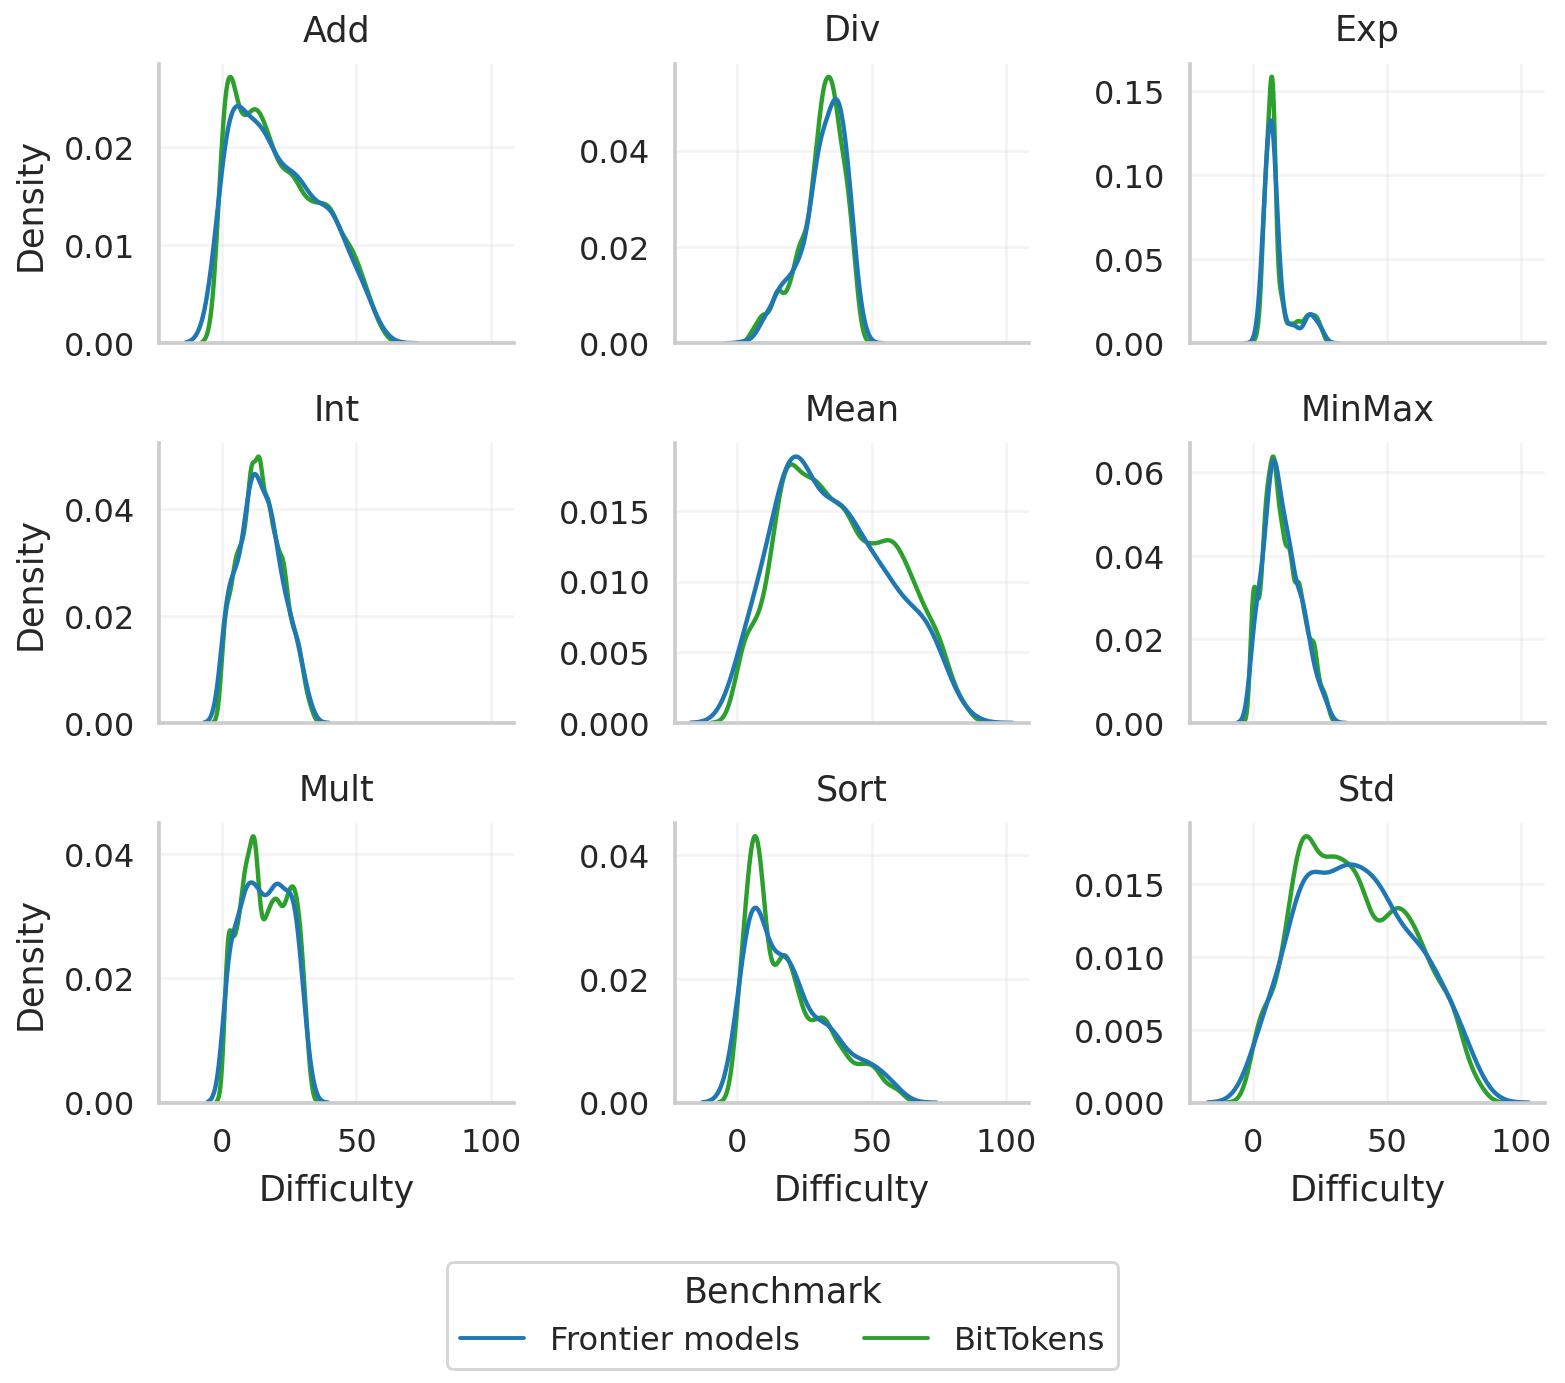

In [ ]:
# Copy/paste this cell into your notebook

from __future__ import annotations

from pathlib import Path
from typing import Iterable, Optional, List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


BASE_DIR = (f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct")

# Tasks from your attachment
TASKS: List[str] = [
    "Addition",
    "Division",
    "Exponentiation",
    "Interval",
    "Mean",
    "MinMax",
    "Multiplication",
    "Sorting",
    "Std",
]


def build_filepath(task: str) -> Path:
    """Return the CSV path for a given task."""
    return BASE_DIR / f"{task}_decimal_uniform_test_10k_shuffle.csv"


def load_task_dataframe(task: str) -> pd.DataFrame:
    """Load the full CSV for a task, returning only the difficulty column with task label."""
    csv_path = build_filepath(task)
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing CSV for task '{task}': {csv_path}")

    # Read only the needed column to reduce I/O and memory
    try:
        df = pd.read_csv(csv_path, usecols=["difficulty_sd"])
    except ValueError as exc:
        # Column not found; help user debug by listing columns
        cols_preview = pd.read_csv(csv_path, nrows=0).columns.tolist()
        raise KeyError(
            f"'difficulty_sd' column not found in {csv_path}. Available columns: {cols_preview}"
        ) from exc

    df = df.rename(columns={"difficulty_sd": "difficulty_sd"}).copy()
    df["task"] = task
    return df


def build_long_dataframe(tasks: Iterable[str]) -> pd.DataFrame:
    """Load all tasks once and construct a long dataframe with subset labels."""
    frames_all: List[pd.DataFrame] = []
    for task in tasks:
        df_task = load_task_dataframe(task)
        # Clean NaNs if any
        df_task = df_task.dropna(subset=["difficulty_sd"])

        # Create labeled subsets without re-reading
        subsets = [
            ("first_500", df_task.head(500)),
            # ("first_1000", df_task.head(1000)),
            ("all", df_task),
        ]
        for subset_name, df_sub in subsets:
            tmp = df_sub[["difficulty_sd", "task"]].copy()
            tmp["subset"] = subset_name
            frames_all.append(tmp)

    long_df = pd.concat(frames_all, axis=0, ignore_index=True)
    return long_df


def compute_common_bins(values: pd.Series, bins: str | int = "fd") -> np.ndarray:
    """Compute common histogram bin edges for consistent overlays."""
    # If too few unique values, fallback to a fixed bin count
    if values.nunique(dropna=True) < 2:
        return np.linspace(values.min(), values.max() + 1e-9, 10)
    return np.histogram_bin_edges(values.to_numpy(), bins=bins)


# Build data
long_df = build_long_dataframe(TASKS)

# Use binning based on all tasks' 'all' subset for comparability
all_mask = long_df["subset"] == "all"
bin_edges = compute_common_bins(long_df.loc[all_mask, "difficulty_sd"], bins="fd")

# Plot settings
sns.set(style="whitegrid", context="talk")
palette = {
    "first_500": "#1f77b4",   # blue
    "first_1000": "#ff7f0e",  # orange
    "all": "#2ca02c",         # green
}

# Faceted overlayed histograms: one column per task, hue by subset
g = sns.displot(
    data=long_df,
    x="difficulty_sd",
    col="task",
    hue="subset",
    kind="kde",
    # bins=bin_edges,
    # stat="density",       # normalize to compare shapes across different sample sizes
    common_norm=False,    # don't force global normalization; keep per-facet densities
    # element="step",       # step-style outlines keep overlays readable
    # fill=False,
    palette=palette,
    col_wrap=3,           # arrange into a grid
    height=3.2,
    aspect=1.2,
    facet_kws=dict(sharex=True, sharey=False),
)

from matplotlib.lines import Line2D

# Desired order + labels
hue_order = ["first_500", "all"]
legend_labels = {
    "first_500": "Frontier models",
    "all": "BitTokens",
}

# Rebuild the plot with a stable hue order and no per-axes legend
plt.close(g.fig)  # close the previous grid to avoid duplicate figures
g = sns.displot(
    data=long_df,
    x="difficulty_sd",
    col="task",
    hue="subset",
    kind="kde",
    common_norm=False,
    palette=palette,
    hue_order=hue_order,
    legend=False,          # <— prevent seaborn from adding legends
    col_wrap=3,
    height=3.2,
    aspect=1.2,
    facet_kws=dict(sharex=True, sharey=False),
)
short_titles = {
    "Addition": "Add",
    "Division": "Div",
    "Exponentiation": "Exp",
    "Interval": "Interval",
    "Mean": "Mean",
    "MinMax": "MinMax",
    "Multiplication": "Mult",
    "Sorting": "Sorting",
    "Std": "Std",
}
g.set_axis_labels("Difficulty", "Density")
for ax, task_name in zip(g.axes.flatten(), g.col_names):
    ax.set_title(short_titles.get(task_name, task_name))
for ax in g.axes.flatten():
    ax.grid(True, alpha=0.2)
# Only include levels that actually appear in the data
present_levels = [lvl for lvl in hue_order if lvl in long_df["subset"].unique()]

# Build custom handles for a single, figure-level legend
handles = [
    Line2D([0], [0], lw=2, color=palette[lvl], label=legend_labels.get(lvl, lvl))
    for lvl in present_levels
]
labels = [legend_labels.get(lvl, lvl) for lvl in present_levels]

g.fig.legend(
    handles,
    labels,
    title="Benchmark",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.0),
    ncol=len(labels),
    frameon=True,
)

OUTDIR = (f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/analysis")

plt.subplots_adjust(top=0.88)  # leave space for the legend
plt.savefig(OUTDIR / "difficulty_sd_distribution_per_task.pdf", bbox_inches="tight")

# Optional: also produce a single-panel overview aggregated across tasks (comment out if not needed)
# plt.figure(figsize=(8, 5))
# sns.kdeplot(
#     data=long_df,
#     x="difficulty_sd",
#     hue="subset",
#     common_norm=False,
#     fill=False,
#     palette=palette,
# )
# plt.title("difficulty_sd distribution aggregated across tasks")
# plt.xlabel("Difficulty")
# plt.ylabel("Density")
# plt.grid(True, alpha=0.2)
# plt.tight_layout()
# plt.savefig(OUTDIR / "difficulty_sd_distribution_aggregated_across_tasks.png")

# Results Figure

/tmp/ipykernel_953766/515654690.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  texts = ax.set_xticklabels(tick_labels, rotation=90, ha="center")
/tmp/ipykernel_953766/515654690.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  texts = ax.set_xticklabels(tick_labels, rotation=90, ha="center")
/tmp/ipykernel_953766/515654690.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  texts = ax.set_xticklabels(tick_labels, rotation=90, ha="center")
/tmp/ipykernel_953766/515654690.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  texts = ax.set_xticklabels(tick_labels, rotation=90, ha="center")
/tmp/ipykernel_953766/515654690.py:180: UserWarning: set

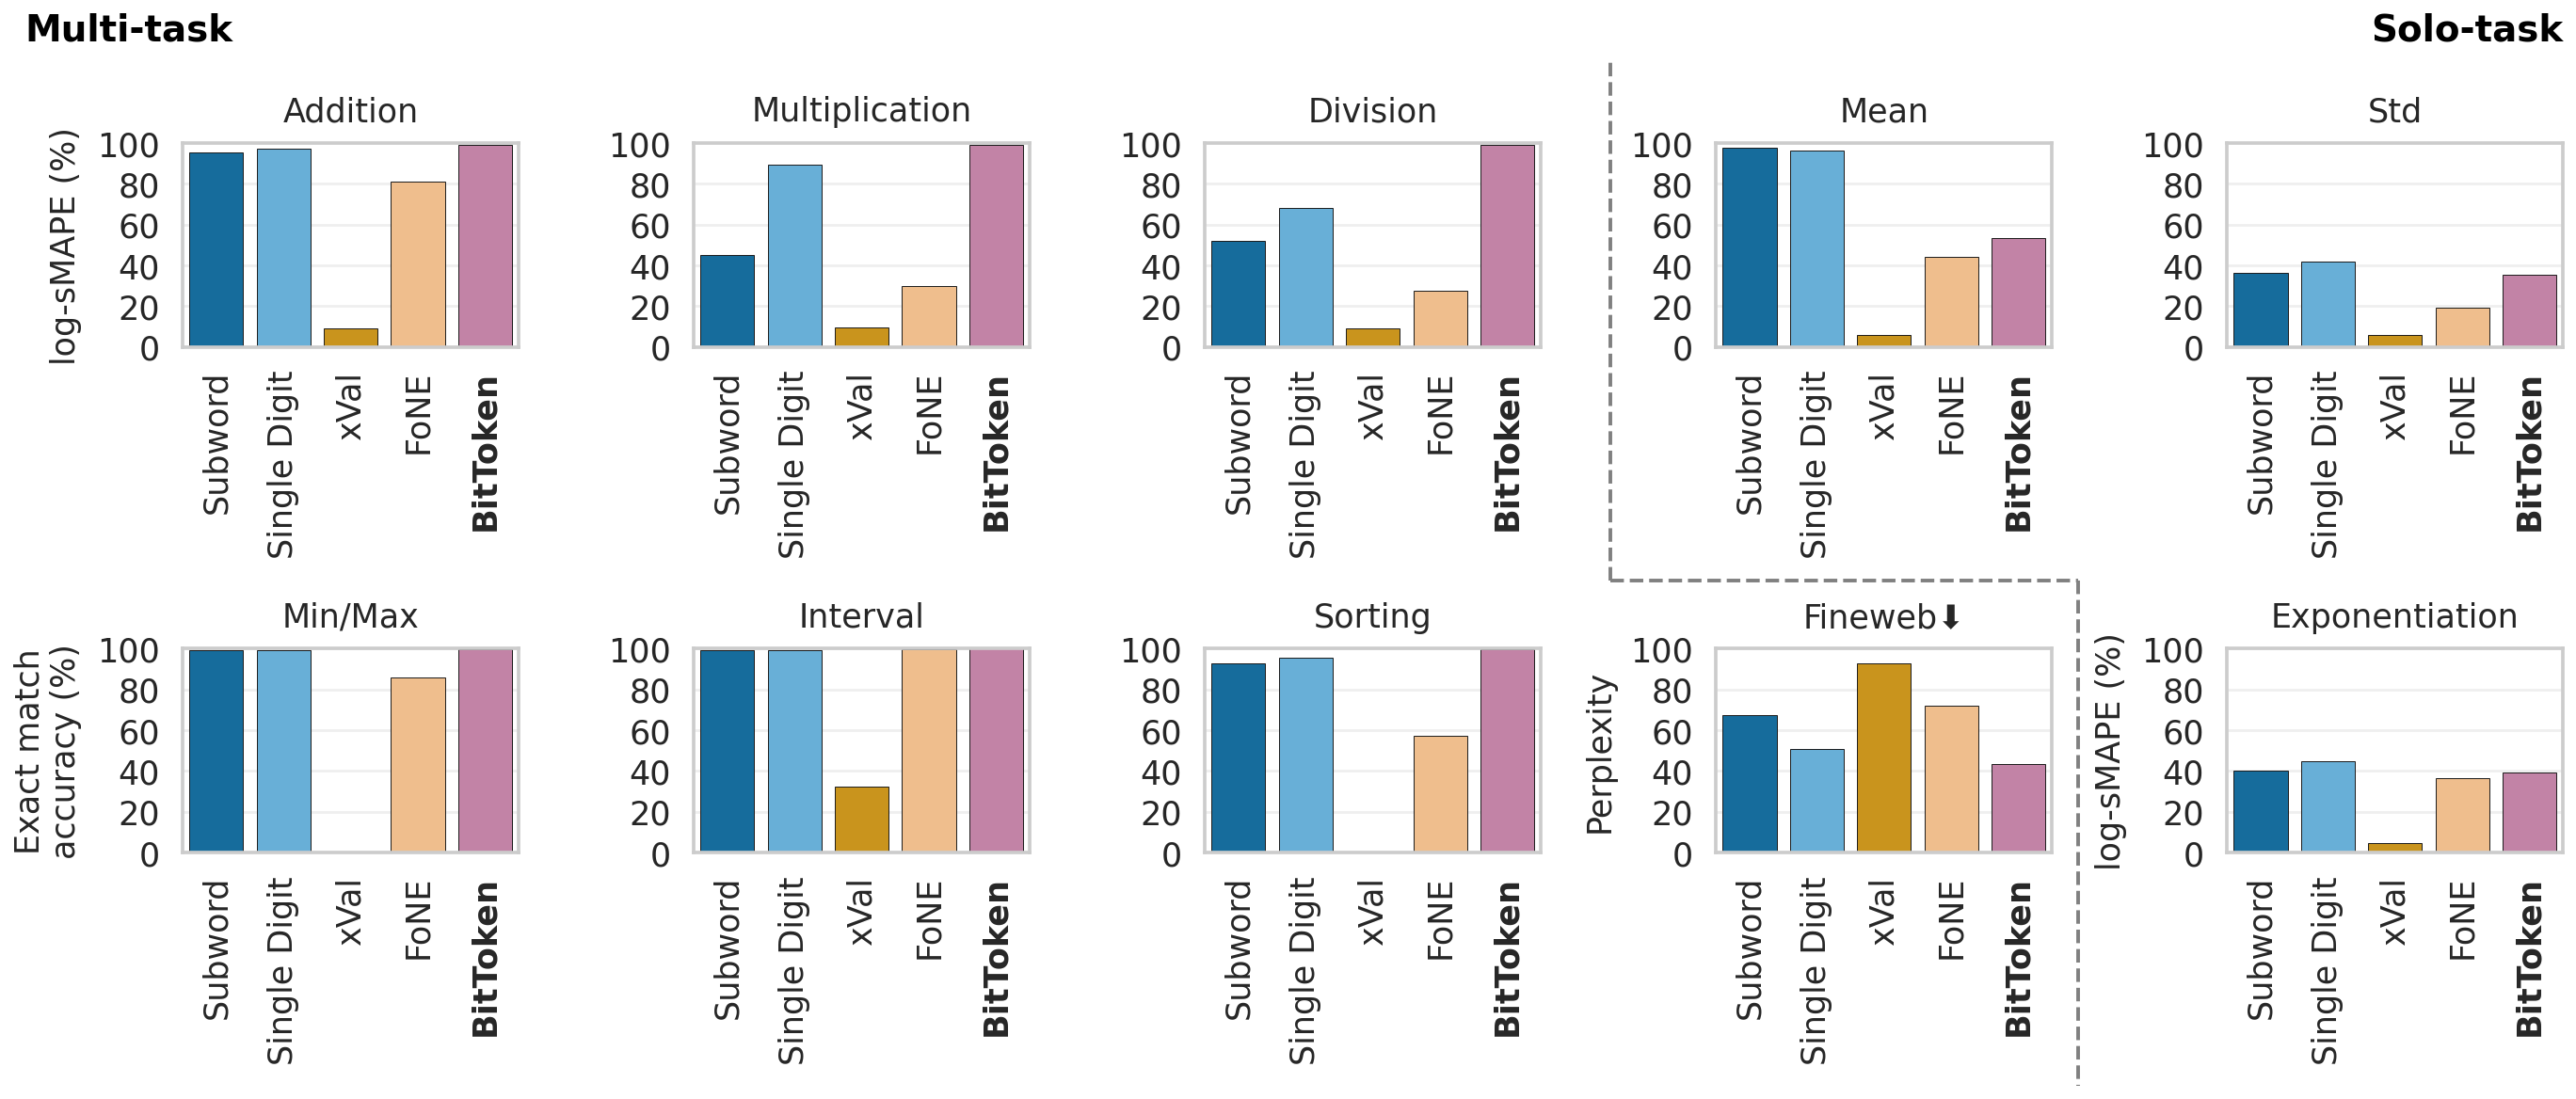

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

# File paths (absolute as requested)
path_multi = f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/multitask.csv"
path_solo  = f"{PROJECT_PATH}/test_data_2025-09-04_shuffled_correct/solotask.csv"

# Read CSVs
df_multi = pd.read_csv(path_multi, dtype=str)
df_solo  = pd.read_csv(path_solo, dtype=str)

# Clean column names and values
df_multi.columns = df_multi.columns.str.strip()
df_solo.columns  = df_solo.columns.str.strip()
for df in (df_multi, df_solo):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.strip()

# Identify model columns from the header order
fixed_cols = ["Task", "Metric"]
model_cols_multi = [c for c in df_multi.columns if c not in fixed_cols]
model_cols_solo  = [c for c in df_solo.columns if c not in fixed_cols]

# Preserve order: start from multitask order, then add any solo-only models at the end
model_order = list(model_cols_multi) + [m for m in model_cols_solo if m not in model_cols_multi]

# Melt to long format and convert scores to numeric
def melt_scores(df, source_label):
    long_df = df.melt(id_vars=["Task", "Metric"], value_vars=[c for c in df.columns if c not in fixed_cols],
                      var_name="Model", value_name="Score")
    long_df["Score"] = pd.to_numeric(long_df["Score"], errors="coerce")
    long_df["source"] = source_label
    return long_df.dropna(subset=["Score"])

long_multi = melt_scores(df_multi, "multi")
long_solo  = melt_scores(df_solo,  "solo")

# Task sets and plotting order
multi_tasks = {"Min/Max", "Interval", "Sorting", "Add", "Mult", "Div", "Fineweb"}
solo_tasks  = {"Exp", "Mean", "Std"}
tasks_order = ["Add", "Mult", "Div",  "Mean", "Std", "Min/Max", "Interval", "Sorting", "Fineweb", "Exp",]

# Select correct source per task
df_all = pd.concat([
    long_multi[long_multi["Task"].isin(multi_tasks)],
    long_solo[long_solo["Task"].isin(solo_tasks)]
], ignore_index=True)

# Compute display value: percentages for non-Perplexity metrics
is_perplexity = df_all["Metric"].str.contains("Perplexity", case=False, na=False)
df_all["ValuePlot"] = np.where(is_perplexity, df_all["Score"], df_all["Score"] * 100.0)

# Drop models with no data across selected tasks
present_models = (
    df_all.groupby("Model")["ValuePlot"]
    .apply(lambda s: np.isfinite(s).any())
    .pipe(lambda s: s[s].index.tolist())
)
model_order = [m for m in model_order if m in present_models]

# --- Replace your palette logic with this ---
OURS = "BitToken (Ours)"

# Palette A (Okabe–Ito inspired)
model_to_color = {
    "Subword": "#0072B2",
    "Single Digit": "#56B4E9",
    "xVal": "#E69F00",
    "FoNE": "#FFBE7D",
    OURS: "#CC79A7",
}

# Keep only colors for present models; preserve your existing model_order
model_to_color = {m: model_to_color[m] for m in model_order if m in model_to_color}

# Styling similar to tokens_vs_performance_matrix.png
sns.set_theme(context="talk", style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlepad": 12,
    "axes.labelpad": 8,
})

# Create 2x5 subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)
axes = axes.flatten()

# Background color for solo-task subplots
solo_bg = "#f0f0f0"

# Sets for y-axis label logic
ylabel_logsmape_tasks = {"Add", "Exp"}
ylabel_remove_tasks = {"Mult", "Mean", "Std", "Interval", "Sorting", "Div"}

# Plot per task
AXIS_LABEL_SIZE = 18
TICK_LABEL_SIZE = 18
SUBPLOT_TITLE_SIZE = 18
for idx, task in enumerate(tasks_order):
    ax = axes[idx]
    sub = df_all[df_all["Task"] == task].copy()
    if sub.empty:
        ax.set_title(task)
        ax.axis("off")
        continue

    # Ensure models are in consistent order and present
    sub["Model"] = pd.Categorical(sub["Model"], categories=model_order, ordered=True)
    sub = sub.sort_values("Model")

    # Grey background for solo tasks
    # if task in solo_tasks:
        # ax.patch.set_facecolor(solo_bg)

    # Barplot: one bar per model
    sns.barplot(
        data=sub,
        x="Model",
        hue="Model",
        y="ValuePlot",
        legend=False,
        order=model_order,
        palette=model_to_color,
        ax=ax,
        edgecolor="k",
        linewidth=0.5
    )

    # Titles
    long_titles = {
        "Add": "Addition",
        "Div": "Division",
        "Exp": "Exponentiation",
        "Interval": "Interval",
        "Mean": "Mean",
        "Min/Max": "Min/Max",
        "Mult": "Multiplication",
        "Sorting": "Sorting",
        "Std": "Std",
        "Fineweb": "Fineweb",
    }

    if task == "Fineweb":
        ax.set_title(task + "⬇", fontsize=SUBPLOT_TITLE_SIZE)
    else:
        ax.set_title(long_titles[task], fontsize=SUBPLOT_TITLE_SIZE)
    ax.set_xlabel("")
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 20, 40, 60, 80, 100])

    # Y label rules

    if task == "Fineweb":
        ax.set_ylabel("Perplexity", fontsize=AXIS_LABEL_SIZE)
    elif task in ylabel_logsmape_tasks:
        ax.set_ylabel("log-sMAPE (%)", fontsize=AXIS_LABEL_SIZE)
    elif task in ylabel_remove_tasks:
        ax.set_ylabel("")
    elif task == "Min/Max":
        ax.set_ylabel("Exact match\naccuracy (%)", fontsize=AXIS_LABEL_SIZE)
    else:
        ax.set_ylabel("Performance (%)")

    # X tick labels: insert newline for BitToken (Ours)
    tick_labels = [t.get_text() for t in ax.get_xticklabels()]
    tick_labels = [
        lbl.replace("BitToken (Ours)", "BitToken") if isinstance(lbl, str) else lbl
    for lbl in tick_labels]
    texts = ax.set_xticklabels(tick_labels, rotation=90, ha="center")
    for text in texts:
        if text.get_text() == "BitToken":
            text.set_fontweight("bold")

    # Grid style
    ax.grid(True, axis="y", alpha=0.3, zorder=0)
    ax.tick_params(axis="x", labelsize=TICK_LABEL_SIZE)
    ax.tick_params(axis="y", labelsize=TICK_LABEL_SIZE)

# Turn off any unused axes (safety)
for j in range(len(tasks_order), len(axes)):
    axes[j].axis("off")

# Build legend beneath the plot
# handles = [Patch(facecolor=model_to_color[m], edgecolor="k", label=m) for m in model_order]
# fig.legend(
#     handles=handles,
#     loc="lower center",
#     bbox_to_anchor=(0.5, -0.1),
#     ncol=min(len(model_order), 5),
#     frameon=True,
#     title="Models",
#     fontsize=16,
#     title_fontsize=16,
# )
# Remove legend

fig.tight_layout()
fig.subplots_adjust(bottom=0.22)  # make room for legend
# Shade the entire subplot slot for the solo tasks (Mean, Std, Exp)
# solo_indices = [tasks_order.index(t) for t in ["Mean", "Std", "Exp"]]
# for i in solo_indices:
#     bbox = axes[i].get_position()  # in figure (0-1) coords
#     fig.add_artist(Rectangle(
#         (bbox.x0, bbox.y0), bbox.width, bbox.height,
#         transform=fig.transFigure,
#         facecolor=solo_bg, edgecolor="none", zorder=0
#     ))
#     axes[i].set_zorder(1)  # keep the axes above the background patch



highlight_axes = [axes[i] for i in [0, 4, 5, 9]]

# Get bounding boxes in figure coordinates
bboxes = [ax.get_position() for ax in highlight_axes]

# Compute combined bounds
x0 = min(b.x0 for b in bboxes) - 0.07
y0 = min(b.y0 for b in bboxes) - 0.2
x1 = max(b.x1 for b in bboxes) + 0.01
y1 = max(b.y1 for b in bboxes) + 0.08

# Create rectangle in figure coordinates
rect = Rectangle(
    (x0, y0), x1 - x0, y1 - y0,
    transform=fig.transFigure,  # use figure coordinates
    fill=False,
    color="grey",
    linewidth=2,
    linestyle="--"
)


# Add label in bottom-right corner of the rectangle
fig.text(
    x1 - 0.01,   # a little inside the right edge
    y1 + 0.01,   # a little above the bottom edge
    "Solo-task",
    ha="right", va="bottom",
    fontsize=20, color="black",
    fontweight="bold"
)

# Add label in bottom-right corner of the rectangle
fig.text(
    x0 + 0.01,   # a little inside the right edge
    y1 + 0.01,   # a little above the bottom edge
    "Multi-task",
    ha="left", va="bottom",
    fontsize=20, color="black",
    fontweight="bold"
)
# Add rectangle to figure
# fig.add_artist(rect)

from matplotlib.lines import Line2D

tl_x = axes[8].get_position().x0 - 0.04
tr_x = axes[8].get_position().x1 + 0.01
t_y = axes[8].get_position().y1 + 0.08

line = Line2D([tl_x, tr_x], [t_y, t_y],
              transform=fig.transFigure,
              color="grey", linewidth=2, linestyle="--")
fig.add_artist(line)

line = Line2D([tl_x, tl_x], [t_y, y1],
              transform=fig.transFigure,
              color="grey", linewidth=2, linestyle="--")
fig.add_artist(line)

line = Line2D([tr_x, tr_x], [t_y, y0],
              transform=fig.transFigure,
              color="grey", linewidth=2, linestyle="--")
fig.add_artist(line)


plt.tight_layout()
plt.savefig(f"PROJECT_PATH/test_data_2025-09-04_shuffled_correct/analysis/results.pdf", bbox_inches="tight")
plt.savefig(f"PROJECT_PATH/test_data_2025-09-04_shuffled_correct/analysis/results.png", bbox_inches="tight")